# Lecture 3 - Locally Weighted & Logical Regression

## Local Weighted Linear Regression
In linear regression, we can compute a hypothesis value for a given value, $x$.

This value however, is based off of all features, and parameters. 

In [19]:
%pip install numpy
%pip install matplotlib
%pip install pandas

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

input_cols = ['Humidity9am', 'Temp9am']
output_col = 'RainToday'

plt.style.use('dark_background')
data = pd.read_csv('datasets/weather.csv',
                   usecols=[*input_cols, output_col])
data.dropna()



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


,Humidity9am,Temp9am,RainToday
0,68,14.4,No
1,80,17.5,Yes
2,82,15.4,Yes
3,62,13.5,Yes
4,68,11.1,Yes
...,...,...,...
361,38,20.4,No
362,45,17.2,No
363,63,14.5,No
364,69,15.8,No


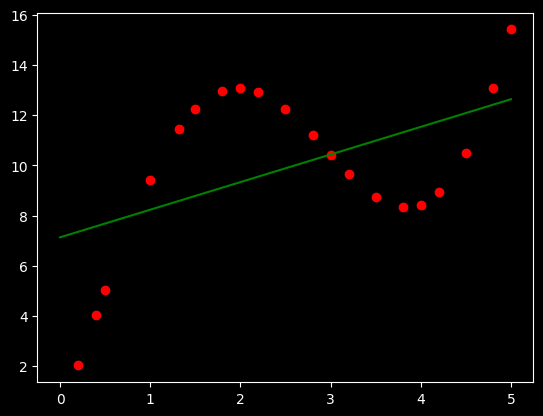

In [25]:

def normal_equation(df: pd.DataFrame):
    X = df[input_cols]
    X = np.c_[np.ones(X.shape[0]), X]
    y = df[output_col]
    return np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

def f(x):
    return x**2 + 10*np.sin(x)

input_cols = ['x']
output_col = 'y'

data = {}
data[input_cols[0]] = np.array([0.2, 0.4, 0.5, 1, 1.32, 1.5, 1.8, 2, 2.2, 2.5, 2.8, 3, 3.2, 3.5, 3.8, 4, 4.2, 4.5, 4.8, 5])
data[output_col] = f(data[input_cols[0]])  
# data = pd.read_csv('datasets/weather.csv',
#                    usecols=[*input_cols, output_col],)
# print(data)
df = pd.DataFrame(data)
df.dropna()

x = df[input_cols].values.flatten()
y = df[output_col].values.flatten()
parameters = normal_equation(df)

plt.scatter(x, y, c='r')

# # Initialize the starting point
# x_0 = 3

# # Plot the function and the progress of gradient descent
hyp_x = np.linspace(0, 5, 100)
hyp_y = parameters[0] + parameters[1] * hyp_x

# # d/dx = 0 : https://www.wolframalpha.com/input?i=2x+%2B+10cos%28x%29+%3D+0
# # Minimum points: -1.30644, 3.83747

plt.plot(hyp_x, hyp_y, label='f(x)', c='g')
# plt.plot(x, y_lr, label='f(x)', c='r')
# # plt.scatter(np.array(min_pts), 
# #             f(np.array(min_pts)), 
# #             c='r', 
# #             label='Miminum points')
# plt.legend()
plt.show()

The hypothesis function is far more accurate at some points than others. Take for instance the gradients of both $x$ ranges, $[2, 3]$ and $[1.5, 2]$. 
The gradients of both functions are drastically different. Thus, the hypothesis function will be more accurate at some points than others.

We consider these ranges as _locals_. Notice, the gradients of points within a local are similar.  

Thus, if we want to only consider based on a _local_, we can use a weight value to determine how much an example should influence the estimation given the point of interest.

To do this, we will modify our cost function, $J(\theta)$, to include a weight value, $w^{(i)}$.
$$J(\theta) = \frac{1}{2}\sum_{i=1}^m w^{(i)}(h_\theta(x^{(i)}) - y^{(i)})^2$$
We can represent this in vectorized form as:
$$J(\theta) = \frac{1}{2}(X\theta - y)^T W (X\theta - y)$$

Where $W$ is a diagonal matrix, where the diagonal values are the weight values, $w^{(i)}$.

$w^{(i)}$ is a weight value that is computed based on some weight function like the following:
$$w^{(i)} = exp\left(-\frac{(x^{(i)} - x)^2}{2\tau^2}\right)$$

In this weight function, notice how we are computing the exponent based on the distance of $x^{(i)}$ from $x$.

$$(x^{(i)} - x)^2$$

If $x$ is 5:
- and $x^{(i)}$ is 5, then this difference is $0$, and the squared difference is $0$.
- and $x^{(i)}$ is 7, then this difference is $2$, and the squared difference is $4$.

In the weight function, we divide this squared difference by $2\tau^2$. $\tau$ is a parameter that determines the 'size' of the local. The larger the $\tau$, the larger the local.

Finally, notice that we take the negative of this value. This is because we want the weight value to be between 0 and 1. When we take the exponent to a negative value, we are essentially inverting the value.

This means that, for distances that are far away from $x$, the weight value will be close to 0, meaning there will be less influence on the hypothesis function. Conversely, for distances that are close to $x$, the weight value will be close to 1, meaning there will be more influence on the hypothesis function.

$$exp\left(-\frac{(x^{(i)} - x)^2}{2\tau^2}\right)$$




In [1]:
%pip install numpy
%pip install matplotlib
%pip install pandas

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Main Implementation of Gradient Descent.

def hypothesis(x: list[float] = [], parameters: list[float] = []):
    # print(f"{x} {parameters}")
    return np.dot(x, parameters)

def calc_cost_for_example(x: list[float] = [], y = 0, parameters: list[float] = []) -> float:
    return (hypothesis(x, parameters) - y)**2

def calc_cost_for_row(row: pd.Series, parameters: list[float] = []) -> float:
    return calc_cost_for_example(
        [1, *map(lambda inp: row[inp], input_cols)],
        row[output_col],
        parameters
    )

def calc_total_cost(df: pd.DataFrame, parameters: list[float] = []) -> float:
    return df.apply(
        lambda row: calc_cost_for_row(row, parameters),
        axis=1
    ).sum()

def calc_average_cost(df: pd.DataFrame, parameters: list[float] = []) -> float:
    return calc_total_cost(df, parameters) / (2 * df.shape[0])

def calc_derrivative_for_example(x: list[float] = [], 
                                 y = 0,
                                 parameters: list[float] = [],
                                 parameter_index = 0) -> float:
    return (hypothesis(x, parameters) - y) * x[parameter_index]

def calc_derrivative_for_row(row: pd.Series, 
                             parameters: list[float] = [],
                             parameter_index = 0) -> float:
    return calc_derrivative_for_example(
        [1, *map(lambda inp: row[inp], input_cols)],
        row[output_col],
        parameters,
        parameter_index
    )

# Sandbox utility functions - not used in the main implementation.
def plot(df: pd.DataFrame, parameter_snapshots: list[list[float]] = []):
    ax = plt.figure().add_subplot(projection='3d')
    ax.set_xlabel(input_cols[0])
    ax.set_ylabel(input_cols[1])
    ax.set_zlabel(output_col)
    for row in df.iterrows():
        ax.scatter(row[1][input_cols[0]], row[1][input_cols[1]], row[1][output_col], c='b')

    # Show all parameter snapshots as a line
    numb_snapshots = len(parameter_snapshots)
    for i in range(numb_snapshots):
        snapshot = parameter_snapshots[i]
        x = np.linspace(-10, 40, 50)
        y = np.linspace(-10, 40, 50)
        z = x * snapshot[1] + y * snapshot[2] + snapshot[0]
        
        color = i == numb_snapshots - 1 and 'r' or 'g'
        ax.plot(x, y, z, c=color)
    plt.show()

def try_out(parameters: list[float] = []):
    print(f"Using parameters: {parameters}")
    while True:
        inp = input("Enter (windSpeed, temperature) or 'q' to quit:")
        if inp == 'q':
            break
        windSpeed, temperature = map(float, inp.split(','))
        rainfall = hypothesis([1, windSpeed, temperature], parameters)
        print(f"Predicted rainfall for {windSpeed}, {temperature}: {rainfall}")


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Logistic Regression
In classification, the hypothesis function produces a desired output.

In this section, we will only consider a case where the desired output is binary, either 0 or 1.

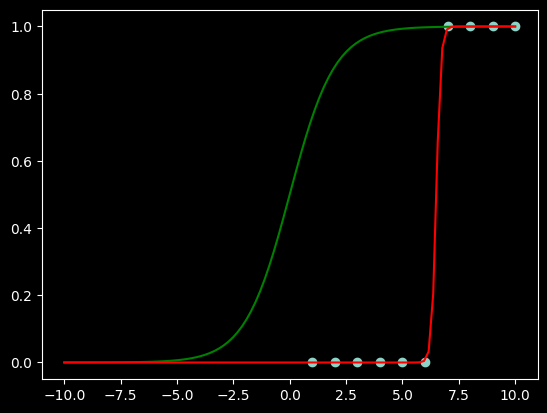

In [24]:
def normal_sigmoid(x):
    return 1 / (1 + np.exp(-x))

def data_fit_sigmoid(x):
    return 1 / (1 + np.exp(-(10 * x - 65)))

x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
y = np.array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1])
x_linespace = np.linspace(-10, 10, 100)
y_dfs_linespace = data_fit_sigmoid(x_linespace)
y_normal_linespace = normal_sigmoid(x_linespace)

plt.scatter(x, y)
plt.plot(x_linespace, y_normal_linespace, c='g')
plt.plot(x_linespace, y_dfs_linespace, c='r')
plt.show()


The sigmoid function (shown in green), $g(x)$, is defined as:
$$g(x) = \frac{1}{1 + e^{-x}}$$

Notice above, the trend of the data starts off from 0 then increases to 1. In fact, we can map the data points using a sigmoid function as shown in red.

We can control the exponent of $e$ to better fit the data. For instance, if we want to fit the data to a sigmoid function, we can modify the sigmoid function like so (shown in red):
$$f(x) = \frac{1}{(1+e^{-(10x - 65)})}$$

The goal of logistic regression is to find the best parameters, $\theta$, that can be used in a sigmoid function, that fit the data.